In [20]:
import keras.models
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cv2
from keras.datasets import mnist
from keras.utils import np_utils
from keras import models
from tensorflow.keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPool2D, Dropout
from tensorflow.keras.optimizers import SGD, Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from keras.utils.np_utils import to_categorical
from sklearn.model_selection import train_test_split
from tqdm import tqdm_notebook
from sklearn.utils import shuffle

In [2]:
data = pd.read_csv("../Data/A_Z Handwritten Data.csv").astype('float32')

X = data.drop('0', axis=1)
y = data['0']

train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.2)

In [3]:
train_X = np.reshape(train_X.values, (train_X.shape[0], 28, 28))
test_X = np.reshape(test_X.values, (test_X.shape[0], 28, 28))

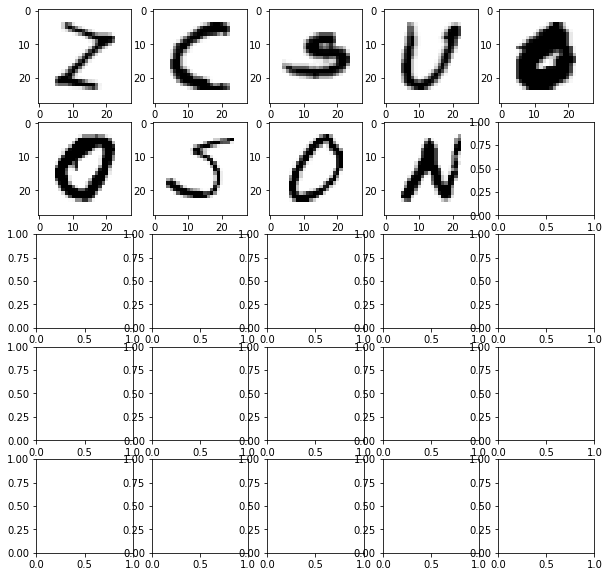

In [4]:
shuff = shuffle(train_X[:100])
fig, ax = plt.subplots(3, 3, figsize=(10, 10))
axes = ax.flatten()
for i in range(9):
    _, shu = cv2.threshold(shuff[i], 30, 200, cv2.THRESH_BINARY)
    axes[i].imshow(np.reshape(shuff[i], (28, 28)), cmap="Greys")
plt.show()

In [5]:
train_X = train_X.reshape(train_X.shape[0], train_X.shape[1], train_X.shape[2], 1)
test_X = test_X.reshape(test_X.shape[0], test_X.shape[1], test_X.shape[2], 1)

train_y = to_categorical(train_y, num_classes=26, dtype='int')
test_y = to_categorical(test_y, num_classes=26, dtype='int')

In [21]:
word_dict = {0: 'A', 1: 'B', 2: 'C', 3: 'D', 4: 'E', 5: 'F', 6: 'G', 7: 'H', 8: 'I', 9: 'J', 10: 'K', 11: 'L', 12: 'M',
             13: 'N', 14: 'O', 15: 'P', 16: 'Q', 17: 'R', 18: 'S', 19: 'T', 20: 'U', 21: 'V', 22: 'W', 23: 'X', 24: 'Y',
             25: 'Z'}

In [7]:
model = Sequential()

model.add(Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=64, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Conv2D(filters=128, kernel_size=(3, 3), activation='relu', padding='valid'))
model.add(MaxPool2D(pool_size=(2, 2), strides=2))

model.add(Flatten())

model.add(Dense(64, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(26, activation="softmax"))

model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

early_stopping = EarlyStopping(
    min_delta=0.001,
    patience=2,
    restore_best_weights=True,
)

In [8]:
history = model.fit(train_X, train_y, validation_data=(test_X, test_y), batch_size=128, epochs=5,
                    callbacks=[early_stopping])
model.summary()
model.save(r'model_hand.h5')
print("The validation accuracy is :", history.history['val_accuracy'])
print("The training accuracy is :", history.history['accuracy'])
print("The validation loss is :", history.history['val_loss'])
print("The training loss is :", history.history['loss'])


2328/2328 [==============================] - 420s 180ms/step - loss: 0.2060 - accuracy: 0.9477 - val_loss: 0.0952 - val_accuracy: 0.9711

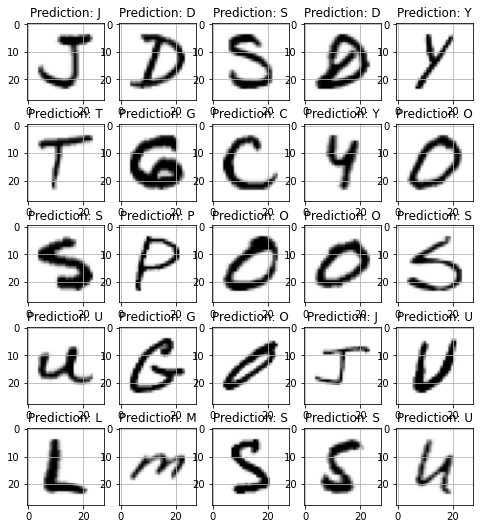

In [9]:
fig, axes = plt.subplots(3, 3, figsize=(8, 9))
axes = axes.flatten()
for i, ax in enumerate(axes):
    img = np.reshape(test_X[i], (28, 28))
    ax.imshow(img, cmap="Greys")

    pred = word_dict[np.argmax(test_y[i])]
    ax.set_title("Prediction: " + pred)
    ax.grid()

In [22]:
img = cv2.imread("../Data/test.png")
img_copy = img.copy()
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = cv2.resize(img, (400, 440))

In [23]:
img_copy = cv2.GaussianBlur(img_copy, (7, 7), 0)
img_gray = cv2.cvtColor(img_copy, cv2.COLOR_BGR2GRAY)
_, img_thresh = cv2.threshold(img_gray, 100, 255, cv2.THRESH_BINARY_INV)
img_final = cv2.resize(img_thresh, (28, 28))
img_final = np.reshape(img_final, (1, 28, 28, 1))

In [24]:
model = models.load_model("model_hand.h5")
img_pred = word_dict[np.argmax(model.predict(img_final))]
cv2.putText(img, "Given Image", (20, 25), cv2.FONT_HERSHEY_SIMPLEX, 0.7, color=(0, 0, 230))
cv2.putText(img, "Prediction: " + img_pred, (20, 410), cv2.FONT_HERSHEY_DUPLEX, 1.3, color=(255, 0, 30))
cv2.imshow('handwritten character recognition ', img)
while True:
    k = cv2.waitKey(1) & 0xFF
    if k == 27:
        break
cv2.destroyAllWindows()

KeyboardInterrupt: 